# Sydney Real Estate

The SurfIntoYourHome LLC from Sydney wants to offer a new service to their clients. Similar to the competition from overseas, the company wants to offer a price estimate of a building to their customers. This is supposed to help the customer evaluate wether the pricing of a building is fair or not. In order for the prediction to work the company has provided a dataset under the CC0: Public Domain License from https://www.kaggle.com/datasets/mihirhalai/sydney-house-prices?select=SydneyHousePrices.csv which has been scraped from the web.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from sklearn.metrics import mean_absolute_error
sns.set(rc={'figure.figsize':(20,10)})

In [2]:
data = pd.read_csv("data/SydneyHousePrices.csv")# for the server/home/jovyan/DeepLearningExperiment/data/SydneyHousePrices.csv")

In [3]:
data.shape

(199504, 9)

In [4]:
data.head()

,Date,Id,suburb,postalCode,sellPrice,bed,bath,car,propType
0,2019-06-19,1,Avalon Beach,2107,1210000,4.0,2,2.0,house
1,2019-06-13,2,Avalon Beach,2107,2250000,4.0,3,4.0,house
2,2019-06-07,3,Whale Beach,2107,2920000,3.0,3,2.0,house
3,2019-05-28,4,Avalon Beach,2107,1530000,3.0,1,2.0,house
4,2019-05-22,5,Whale Beach,2107,8000000,5.0,4,4.0,house


The dataset contains 199504 rows and has 9 columns.

In [5]:
data["sellPrice"].max()

2147483647

In [6]:
data.describe()

,Id,postalCode,sellPrice,bed,bath,car
count,199504.00000,199504.000000,1.995040e+05,199350.000000,199504.000000,181353.000000
mean,99752.50000,2196.379155,1.269776e+06,3.516479,1.890669,1.936224
std,57591.98839,193.053467,6.948239e+06,1.066555,0.926001,1.060237
min,1.00000,2000.000000,1.000000e+00,1.000000,1.000000,1.000000
25%,49876.75000,2082.000000,7.200000e+05,3.000000,1.000000,1.000000
50%,99752.50000,2144.000000,9.850000e+05,3.000000,2.000000,2.000000
75%,149628.25000,2211.000000,1.475000e+06,4.000000,2.000000,2.000000
max,199504.00000,4878.000000,2.147484e+09,99.000000,99.000000,41.000000


The dataset contains property that has been sold for 1 AUD up to 2 billion dollar. This is clearly a mistake and during the data cleaning those extreme values will be removed. the lower values for bedrooms, bathrooms and car parking spots seem plausible as they are all 1. However, the max values for bed and bathrooms of 99 seems implausible. The same applies for the car parking with 41. Even if those values are true the company is focused on singles and families and not real estate developers, therefor those values can be excluded from the prediction.

For this purpose the dataset will be filtered to only keep listings with a price lower than or equal to 4 Mio AUD. For the bedrooms, bathrooms and car parking lots a filter of 10 is applied. 

Because the company gets paid a percentage off the price the property is sold for they are only interested in ones that are valued at a minimum of 500,000 AUD.

In [7]:
data_filtered = data[data["sellPrice"]<= 4000000]
data_filtered = data_filtered[data_filtered["sellPrice"]>= 500000]
data_filtered = data_filtered[data_filtered["bed"]<= 10]
data_filtered = data_filtered[data_filtered["bath"]<= 10]
data_filtered = data_filtered[data_filtered["car"]<= 10]

In [8]:
data_filtered.describe()

,Id,postalCode,sellPrice,bed,bath,car
count,166356.000000,166356.000000,1.663560e+05,166356.000000,166356.000000,166356.000000
mean,98963.169961,2195.212977,1.221979e+06,3.603417,1.949392,1.938187
std,57529.026686,185.510444,6.403501e+05,0.945752,0.833357,0.978318
min,1.000000,2000.000000,5.000000e+05,1.000000,1.000000,1.000000
25%,48374.750000,2090.000000,7.600000e+05,3.000000,1.000000,1.000000
50%,99139.500000,2146.000000,1.020000e+06,4.000000,2.000000,2.000000
75%,149105.250000,2211.000000,1.499125e+06,4.000000,2.000000,2.000000
max,199504.000000,4217.000000,4.000000e+06,10.000000,10.000000,10.000000


The resulting dataset appears to be more plausible now. The average real estate object has now a price of roughly 990000 AUD, which contains 3.6 bedrooms, almost 2 bathrooms and 2 car parking plots. 

As a next step the year of the sale will be extracted as feature. The prices in the sydney are mostlikely be correlated to the year of the sale.


In [9]:
type(data_filtered["Date"][0])

str

The date is saved as string so the year can be extracted rather easily.

In [10]:
data_filtered["year"] = pd.to_numeric(data_filtered["Date"].str[:4])

In [11]:
data_filtered.groupby("year")["sellPrice"].count()

year
2000        1
2001        3
2002        1
2003        6
2004       32
2005       78
2006      110
2007      553
2008     2632
2009     5506
2010     6906
2011     7719
2012     8960
2013    14163
2014    19348
2015    22825
2016    23025
2017    25048
2018    21053
2019     8387
Name: sellPrice, dtype: int64

Becasue most of the values are in the range from 2009 to 2019, all values before that will be excluded. 2009 will be set as year 1 for the prediction. The idea of setting the date as this type of vaiable is that in general the housing prices are increasing year over year [2]. This is not always true especially in times of crises the prices can drop from the year before. However, most of the time the prices of houses increase year over year. 

In [12]:
data_filtered = data_filtered[data_filtered["year"]>=2009]

In [13]:
data_filtered["year_norm"] = data_filtered["year"] -2008

<AxesSubplot:xlabel='year', ylabel='sellPrice'>

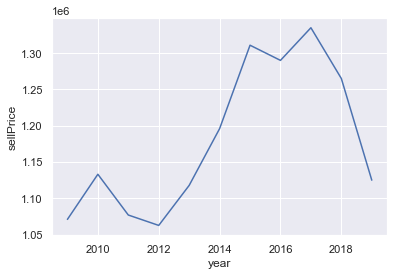

In [14]:
sns.lineplot(x=data_filtered.groupby("year")["sellPrice"].mean().round(0).index[:], y= data_filtered.groupby("year")["sellPrice"].mean().round(0)[:])


The grafic above shows the varation of the average price over the years.
# Under assumption same offering on the market

Next the property types will be evaluated.

In [15]:
data_filtered.groupby("propType")["propType"].count()

propType
acreage                     10
duplex/semi-detached      5691
house                   139422
other                      146
terrace                    696
townhouse                12758
villa                     4199
warehouse                   18
Name: propType, dtype: int64

As mentioned before the client is manly interessted in selling housing to people who will actually move in to the property. Therefor warehouses and acreage can be removed as they are not important for this business goal. In addition to this the category other will be removed. THis leaves the property types "duplex/semi-detached","house","townhouse","villa", "terrace".

In [16]:
data_filtered = data_filtered[data_filtered["propType"].isin(["duplex/semi-detached","house","townhouse","villa", "terrace"])]

As a last step the location will be taken into consideration. Location is most likely one key factor of the price of housing. There are two possible features that can be used to take this into consideration. Option one is to use the suburb. The problem here is that there are 669 unique suburbs in the dataset. This is most likely to fine in granularity. Therefor two datasets will be generated. One with the raw suburbs as input and one with the suburbs clustered with the average number of bedrooms, bathrooms and average price of the suburb. The second option from the dataset is to use teh ZIP code. This however is not as fine in granularity and therefor most likely not as well suited for this analysis. ZIP codes will be dropped later.

In [17]:

data_all_suburbs = pd.get_dummies(data_filtered,drop_first=True, columns=["propType","suburb"])
data_all_suburbs_final = data_all_suburbs.dropna(how="any")

In [18]:
data_all_suburbs_final.shape

(162766, 677)

This is the first dataset for experimentation with all suburbs as dummy and all the NA values removed, resulting in a dataset with 162,766 properties for the models to train on. It is made up of 677 features.

In [19]:
suburbs = data_filtered.groupby("suburb")["sellPrice", "bed", "bath"].mean()

/var/folders/yy/_cw27tn144d2ztdvqlwsqwt00000gp/T/ipykernel_56550/33837120.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  suburbs = data_filtered.groupby("suburb")["sellPrice", "bed", "bath"].mean()


In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import k_means
scaler = MinMaxScaler()
X = scaler.fit_transform(suburbs)
Y = k_means(X,n_clusters=20, random_state = 42)

In [21]:
suburbs["cluster"] = Y[1]

In [22]:
suburbs = suburbs.reset_index()

In [23]:
suburbs.drop(["sellPrice", "bed", "bath"], axis=1, inplace=True)

In [24]:
data_clustered_suburbs = data_filtered.merge(suburbs, on="suburb")

In [25]:
data_clustered_suburbs.drop(["Date","Id","suburb", "postalCode", "year"], axis=1,inplace=True)


In [26]:
data_clustered_suburbs_final = pd.get_dummies(data_clustered_suburbs,drop_first=True, columns=["propType","cluster"] )

In [27]:
data_clustered_suburbs_final

,sellPrice,bed,bath,car,year_norm,propType_house,propType_terrace,propType_townhouse,propType_villa,cluster_1,...,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,1210000,4.0,2,2.0,11,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2250000,4.0,3,4.0,11,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1530000,3.0,1,2.0,11,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1510000,3.0,1,2.0,11,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1500000,5.0,4,4.0,11,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162761,1610000,5.0,3,6.0,8,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
162762,1330000,4.0,2,2.0,7,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
162763,1100000,5.0,3,2.0,7,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
162764,850000,4.0,2,2.0,6,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# Clustered Data 

## Baseline

# Split train test muss noch ergänzt werden

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import math

In [29]:
Results = []

In [30]:
y_1 = data_clustered_suburbs_final["sellPrice"]
X_1 = data_clustered_suburbs_final.drop(["sellPrice"], axis=1)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2, random_state = 42, shuffle=True)


In [31]:
Y = pd.DataFrame(y_1_test)
avgSellPrice = y_1_train.mean()
Y["avgSellPrice"] = avgSellPrice

In [32]:
RMSE = math.sqrt(mean_squared_error(Y["sellPrice"],Y["avgSellPrice"]))
MAE = mean_absolute_error(Y["sellPrice"],Y["avgSellPrice"])
MAPE = mean_absolute_percentage_error(Y["sellPrice"],Y["avgSellPrice"])


In [33]:
Results.append({"name":"baseline","scores":{"RMSE":RMSE,"MAE":MAE,"MAPE":MAPE}})

In [34]:
print(Results)

[{'name': 'baseline', 'scores': {'RMSE': 641322.4107369833, 'MAE': 486128.33970587794, 'MAPE': 0.45066580547305596}}]


## Machine Learning 

In [35]:
# For jupyterserver to load the pipeline
import os
import sys
module_path = os.path.abspath(os.path.join('..')) + "/jovyan/DeepLearningExperiment"
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/FHKrieg/Projekte/jovyan/DeepLearningExperiment


In [36]:
from Pipline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



Radom Forrest
-----------------
RMSE: 350175.5380221941
MAE: 230352.9224143853
The best results achieved with parameters: {'criterion': 'squared_error', 'max_depth': 80}
Time: 195 seconds (3 minutes)


/opt/homebrew/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


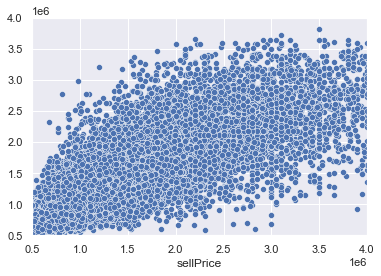



LinearRegression
-----------------
RMSE: 370111.50137377874
MAE: 260835.87298292347
The best results achieved with parameters: {}
Time: 2 seconds (0 minutes)


/opt/homebrew/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


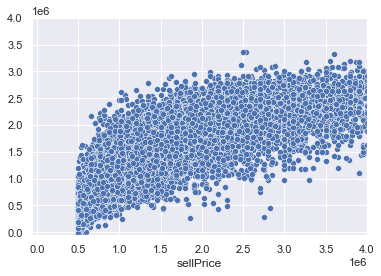

In [37]:
pipe1 = Pipeline(False,3,5)
experiments = [{"name":"Radom Forrest",
    "model":RandomForestRegressor(n_jobs=-1),
    "parameters":{
        "criterion":["squared_error"],
        "max_depth":[30,80,100,200,300]
    }},
    {"name":"LinearRegression",
    "model":LinearRegression(n_jobs=-1),
    "parameters":{
    }}]
resultsML = pipe1.run_experiments_float(experiments,X=X_1_train,Y=y_1_train,Scaler=MinMaxScaler(), scoring="neg_mean_squared_error")

Model 1 best -> chooseb from resultsML[0]

In [38]:
X_1_test_ML_scaled = resultsML[0]["scaler"].transform(X_1_test)
y_hat = resultsML[0]["trained_model"].predict(X_1_test_ML_scaled)
RMSE = math.sqrt(mean_squared_error(y_1_test,y_hat))
MAE = mean_absolute_error(y_1_test,y_hat)
MAPE = mean_absolute_percentage_error(y_1_test,y_hat)
Results.append({"name":resultsML[0]["name"],"scores":{"RMSE":RMSE,"MAE":MAE,"MAPE":MAPE}})

In [39]:
print(Results)

[{'name': 'baseline', 'scores': {'RMSE': 641322.4107369833, 'MAE': 486128.33970587794, 'MAPE': 0.45066580547305596}}, {'name': 'Radom Forrest', 'scores': {'RMSE': 347659.74978114327, 'MAE': 228452.12832370398, 'MAPE': 0.18016232558075485}}]


## Neuronales Netz

In [40]:
import torch
import copy
#for M1 gpu acceleration



In the following section the data will be prepared so it can be inserted into the neural network.

In [41]:
# TODO datapreparation for y and x val and train 
y_scaler = MinMaxScaler()
scaler = MinMaxScaler()
#shuffle not needed here as the data has been shuffled when the data was split in the first place
NN_X_1_train, NN_X_1_val, NN_y_1_train, NN_y_1_val= train_test_split(X_1_train, y_1_train, test_size = 0.2)
NN_X_1_train_scaled = scaler.fit_transform(NN_X_1_train)
NN_X_1_val_scaled = scaler.transform(NN_X_1_val)
NN_X_1_test_scaled = scaler.transform(X_1_test)
NN_y_1_train_scaled = y_scaler.fit_transform(NN_y_1_train.to_numpy().reshape(-1, 1))
NN_y_1_val_scaled = y_scaler.transform(NN_y_1_val.to_numpy().reshape(-1, 1))
#Generation of the Tensors that will be used for the training and prediciton 
NN_X_1_train_scaled_tensor = torch.Tensor(NN_X_1_train_scaled)
NN_X_1_val_scaled_tensor = torch.Tensor(NN_X_1_val_scaled)
NN_X_1_test_scaled_tensor = torch.Tensor(NN_X_1_test_scaled)
NN_y_1_train_tensor = torch.Tensor(NN_y_1_train_scaled)
NN_y_1_val_tensor = torch.Tensor(NN_y_1_val_scaled)

In [42]:
def Grid_Search_NN(model_train, parameters, y_train,y_val, y_train_tensor_scaled,y_val_tensor_scaled,X_train_tensor,X_val_tensor, y_scaler, epochs):
    

    #https://stackoverflow.com/questions/38721847/how-to-generate-all-combination-from-values-in-dict-of-lists-in-python
    keys, values = zip(*parameters.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_rmse=float('inf')
    for combination in permutations_dicts:
        model = copy.deepcopy(model_train)
        if combination["optimizer"] == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=combination["learning_rate"])
        elif combination["optimizer"] == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=combination["learning_rate"])
        else:
            print("Invalid Optimizer using ADAM instead")
            optimizer = torch.optim.Adam(model.parameters(), lr=combination["learning_rate"])
        criterion = combination["criterion"]
        print("---------------------------------------------------")
        print("Now training the model with the following parameteres:")
        for key, value in combination.items():
            print(f"{key} = {value}")
        print()
        print()
        best_rmse_val, best_loss_val, best_model, best_epoch, loss_train, loss_val = training_the_model(model,y_train,y_val, y_train_tensor_scaled,y_val_tensor_scaled,X_train_tensor,X_val_tensor, optimizer, criterion, y_scaler, epochs)
        #Best model is selected on the basis of the rmse score on the validation data in the epoch with the lowest loss for the defined loss function 
        if best_rmse_val< best_rmse:
            best_rmse=best_rmse_val
            best_loss=best_loss_val
            best_model_GS = best_model
            best_epoch_GS=best_epoch
            best_params = combination
            loss_train_best = loss_train
            loss_val_best = loss_val

    print("***************************************************************")
    print(f"The model performed best with those parameters: {best_params}")
    print(f"The best loss for the validation dataset achieved was: {best_rmse}")
    print("***************************************************************")
    return {
        "best_rmse": best_rmse,
        "best_loss": best_loss,
        "best_model": best_model_GS,
        "best_epoch": best_epoch_GS,
        "best_params": best_params,
        "loss_train_best": loss_train_best,
        "loss_val_best": loss_val_best
    }
            

In [43]:
def training_the_model(model,y_train,y_val, y_train_tensor_scaled,y_val_tensor_scaled,X_train_tensor,X_val_tensor, optimizer, criterion, y_scaler, epochs):
    #Aus dem Kurs angepasst
    best_loss_val=float('inf')
    best_rmse_val=float('inf')
    best_model=copy.deepcopy(model)
    best_epoch=0
    loss_train = []
    loss_val = []
    
    for epoch in range(epochs):
        model.train()
        y_train_pred = model(X_train_tensor)
        optimizer.zero_grad()
        loss_train_c = criterion(y_train_pred, y_train_tensor_scaled)
        loss_train_c.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            loss_val_c=criterion(y_val_pred, y_val_tensor_scaled)
            rmse_train = math.sqrt(mean_squared_error(y_train, y_scaler.inverse_transform(y_train_pred)))
            rmse_val= math.sqrt(mean_squared_error(y_val, y_scaler.inverse_transform(y_val_pred)))
            loss_train.append(rmse_train)
            loss_val.append(rmse_val)
            #model is selected with the lowest loss on the validation dataset
            if loss_val_c.item()< best_loss_val:
                best_rmse_val = rmse_val
                best_loss_val=loss_val_c.item()
                best_model = copy.deepcopy(model)
                best_epoch=epoch
        # Add early stop function
        if (epoch % 20==19):
            print("Epoch: %d, loss in training: %1.5f loss in val: %1.5f" % (epoch, loss_train_c.item(), loss_val_c.item()))
    return best_rmse_val, best_loss_val, best_model, best_epoch, loss_train, loss_val

Through testing Adam appears to be the best optimizer for the data so this one will be used in the following experiments

In [44]:
NN_experiments = {
    "parameters": {
        "learning_rate":[0.001, 0.005, 0.01, 0.05],
        "criterion":[ torch.nn.MSELoss(), torch.nn.L1Loss()],
        "optimizer":["Adam"]  
    }
}

In [45]:
from NeuralNets import NN_32_1, NN_64_2, NN_128_3

In [46]:
Models = []

In [47]:
#Model initialization with random seed directly on top to guarantee it is applied in the same way to all models
torch.manual_seed(42)
Models.append(NN_32_1(NN_X_1_train_scaled_tensor.shape[1]))
torch.manual_seed(42)
Models.append(NN_64_2(NN_X_1_train_scaled_tensor.shape[1]))
torch.manual_seed(42)
Models.append(NN_128_3(NN_X_1_train_scaled_tensor.shape[1]))

In [48]:
resultsNN = []
for model in Models:
    resultsNN.append(Grid_Search_NN(model, NN_experiments["parameters"], NN_y_1_train,NN_y_1_val, NN_y_1_train_tensor,NN_y_1_val_tensor,NN_X_1_train_scaled_tensor,NN_X_1_val_scaled_tensor, y_scaler, 1400))

---------------------------------------------------
Now training the model with the following parameteres:
learning_rate = 0.001
criterion = MSELoss()
optimizer = Adam


Epoch: 19, loss in training: 0.05198 loss in val: 0.04951
Epoch: 39, loss in training: 0.02574 loss in val: 0.02545
Epoch: 59, loss in training: 0.02053 loss in val: 0.02027
Epoch: 79, loss in training: 0.01713 loss in val: 0.01691
Epoch: 99, loss in training: 0.01538 loss in val: 0.01516
Epoch: 119, loss in training: 0.01427 loss in val: 0.01404
Epoch: 139, loss in training: 0.01340 loss in val: 0.01318
Epoch: 159, loss in training: 0.01260 loss in val: 0.01239
Epoch: 179, loss in training: 0.01193 loss in val: 0.01175
Epoch: 199, loss in training: 0.01141 loss in val: 0.01127
Epoch: 219, loss in training: 0.01106 loss in val: 0.01095
Epoch: 239, loss in training: 0.01083 loss in val: 0.01074
Epoch: 259, loss in training: 0.01067 loss in val: 0.01059
Epoch: 279, loss in training: 0.01056 loss in val: 0.01049
Epoch: 29

In [49]:
#Pick the best NN on the basis of the best rmse score achieved on the validation data
winnerNN = resultsNN[0]
for resNN in resultsNN:
    if resNN["best_rmse"] < winnerNN["best_rmse"]:
        winnerNN = resNN
    elif resNN["best_rmse"] == winnerNN["best_rmse"]:
        print("Two models performed equally good")

Two models performed equally good


In [50]:
with torch.no_grad():
    y_test_predict = y_scaler.inverse_transform(winnerNN["best_model"](NN_X_1_test_scaled_tensor))
RMSE = math.sqrt(mean_squared_error(y_1_test,y_test_predict))
MAE = mean_absolute_error(y_1_test,y_test_predict)
MAPE = mean_absolute_percentage_error(y_1_test,y_test_predict)
Results.append({"name":"Neural Network","scores":{"RMSE":RMSE,"MAE":MAE,"MAPE":MAPE}})
Results

[{'name': 'baseline',
  'scores': {'RMSE': 641322.4107369833,
   'MAE': 486128.33970587794,
   'MAPE': 0.45066580547305596}},
 {'name': 'Radom Forrest',
  'scores': {'RMSE': 347659.74978114327,
   'MAE': 228452.12832370398,
   'MAPE': 0.18016232558075485}},
 {'name': 'Neural Network',
  'scores': {'RMSE': 330742.7955678935,
   'MAE': 219459.66022545565,
   'MAPE': 0.17345209662945563}}]

675


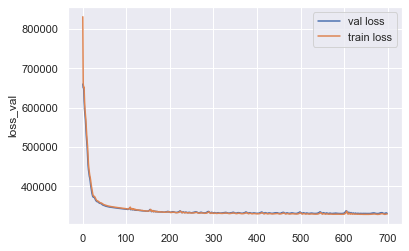

In [53]:
import matplotlib.pyplot as plt
overfittingDF = pd.DataFrame()
overfittingDF["loss_train"] = winnerNN["loss_train_best"]
overfittingDF["loss_val"] = winnerNN["loss_val_best"]
print(winnerNN["best_epoch"])
sns.lineplot(data=overfittingDF, x=overfittingDF.index , y ="loss_val")
sns.lineplot(data=overfittingDF, x=overfittingDF.index , y ="loss_train", palette=["red"])
plt.legend(labels=["val loss", "train loss"])

Eventhough still improving small improvment no overfitting 


In [ ]:
# run model 1 and than use test data to evaluate

In [ ]:
rs=  Grid_Search_NN(TestModel, NN_experiments["parameters"], NN_y_1_train,NN_y_1_val, NN_y_1_train_tensor,NN_y_1_val_tensor,NN_X_1_train_scaled_tensor,NN_X_1_val_scaled_tensor, y_scaler, 100)

In [ ]:
with torch.no_grad():
    y_test_predict = y_scaler.inverse_transform(rs["best_model_CV"](NN_X_1_test_scaled_tensor).cpu())
RMSE = math.sqrt(mean_squared_error(y_1_test,y_test_predict))
MAE = mean_absolute_error(y_1_test,y_test_predict)
MAPE = mean_absolute_percentage_error(y_1_test,y_test_predict)
Results.append({"name":"Neural Network","scores":{"RMSE":RMSE,"MAE":MAE,"MAPE":MAPE}})

In [ ]:
NN_X_1_test_scaled_tensor.shape

In [ ]:
Results

In [ ]:
math.sqrt(rs["best_rmse"])

In [ ]:
rs["best_epoch_CV"]

In [ ]:
from torch import nn

In [ ]:
class NN_64_2_T(nn.Module):

    def __init__(self, input_size):
        super(NN_64_2_T, self).__init__()
                
        self.hidden_1 = nn.Linear(input_size, 32)
        self.output = nn.Linear(32,1)
        #from https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE

        
 
    def forward(self, x):

        out1 = nn.Sigmoid()(self.hidden_1(x))
        return self.output(out1)

# Full dataset

In [ ]:
data_all_suburbs_final = data_all_suburbs_final.drop(["Date", "Id", "postalCode", "year"], axis=1)
data_all_suburbs_final

In [ ]:
y_2 = data_all_suburbs_final["sellPrice"]
X_2 = data_all_suburbs_final.drop("sellPrice", axis=1)
X_2_train, X_2_test, y_2_train,y_2_test = train_test_split(X_2,y_2, test_size=0.3,shuffle=True)

In [ ]:
y_scaler2 = MinMaxScaler()
scaler2 = MinMaxScaler()
#shuffle not needed here as the data has been shuffled when the data was split in the first place
NN_X_2_train, NN_X_2_val, NN_y_2_train, NN_y_2_val= train_test_split(X_2_train, y_2_train, test_size = 0.2)
NN_X_2_train_scaled = scaler2.fit_transform(NN_X_2_train)
NN_X_2_val_scaled = scaler2.transform(NN_X_2_val)
NN_X_2_test_scaled = scaler2.transform(X_2_test)
NN_y_2_train_scaled = y_scaler2.fit_transform(NN_y_2_train.to_numpy().reshape(-1, 1))
NN_y_2_val_scaled = y_scaler2.transform(NN_y_2_val.to_numpy().reshape(-1, 1))
#Generation of the Tensors that will be used for the training and prediciton 
NN_X_2_train_scaled_tensor = torch.Tensor(NN_X_2_train_scaled)
NN_X_2_val_scaled_tensor = torch.Tensor(NN_X_2_val_scaled)
NN_X_2_test_scaled_tensor = torch.Tensor(NN_X_2_test_scaled)
NN_y_2_train_tensor = torch.Tensor(NN_y_2_train_scaled)
NN_y_2_val_tensor = torch.Tensor(NN_y_2_val_scaled)

In [ ]:
#Model initialization with random seed directly on top to guarantee it is applied in the same way to all models
torch.manual_seed(42)
TestModel2 = NN_512_5(NN_X_2_train_scaled_tensor.shape[1])


In [ ]:
rs2=  Grid_Search_NN(TestModel2, NN_experiments["parameters"], NN_y_2_train,NN_y_2_val, NN_y_2_train_tensor,NN_y_2_val_tensor,NN_X_2_train_scaled_tensor,NN_X_2_val_scaled_tensor, y_scaler2, 500)

In [ ]:
math.sqrt(rs2["best_rmse"])

[1] https://www.smh.com.au/property/news/it-s-crazy-sydney-house-prices-surge-55-per-cent-in-less-than-three-years-20220210-p59vck.html, 15.06.2022.  
[2] https://www.cnbc.com/2017/06/23/how-much-housing-prices-have-risen-since-1940.html, 15.06.2022.